# Прикладной пример тройного экспоненциального сглаживания

[Ссылка на источник](https://medium.com/codex/introduction-to-time-series-forecasting-smoothing-methods-9a904c00d0fd)

In [2]:
import itertools
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Загрузка и подготовка данных

Загружаем данные в датафрейм, одновременно столбец "Month" делаем столбцом иднексов

In [21]:
series = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
series.set_index("Month", inplace=True)
series.head()

,Count
Month,
1966-01,41
1966-02,39
1966-03,50
1966-04,40
1966-05,43


Изменим тип данных индекса с "object" на "datetime"

In [59]:
series.index = pd.to_datetime(series.index)

In [60]:
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118 entries, 1966-01-01 to 1975-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Count   118 non-null    int64
dtypes: int64(1)
memory usage: 1.8 KB


Визуализация:

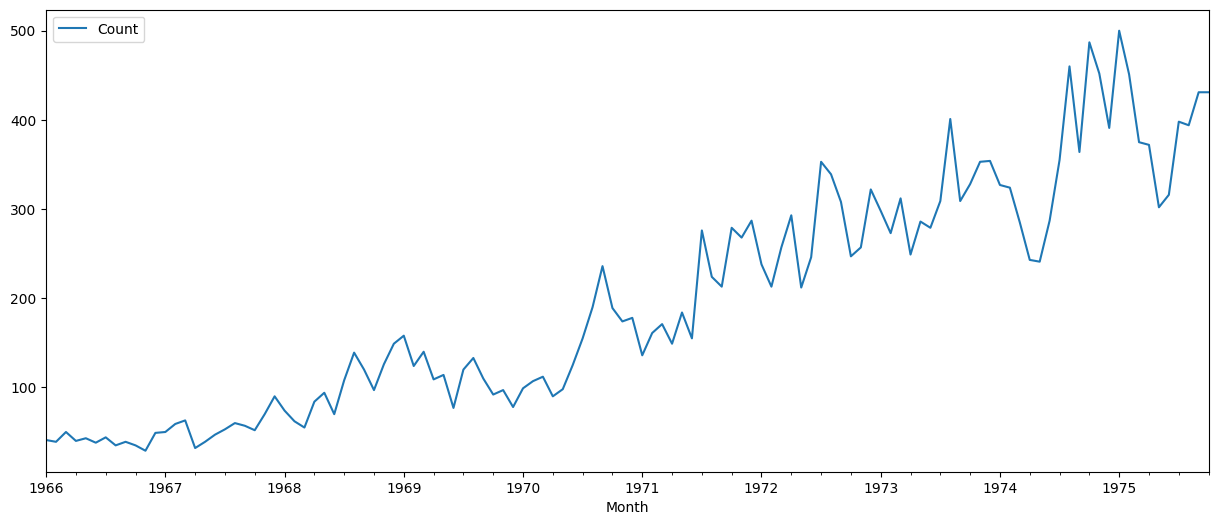

In [61]:
series.plot(figsize=(15, 6))
plt.show()

## Создание TES модели

In [63]:
series.shape

(118, 1)

In [64]:
train, test = series[:100], series[100:]
train.shape, test.shape

((100, 1), (18, 1))

Обучение модели:

In [156]:
tes_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal="add",
    seasonal_periods=12
).fit(
    smoothing_level=0.2,
    smoothing_trend=0.05,
    smoothing_seasonal=0.3
)

/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Сделаем предсказание 30 значений:

In [157]:
pred = tes_model.forecast(18)

In [158]:
pred = pd.DataFrame(pred)

In [159]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18 entries, 1974-05-01 to 1975-10-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       18 non-null     float64
dtypes: float64(1)
memory usage: 288.0 bytes


In [160]:
pred.head()

,0
1974-05-01,304.272827
1974-06-01,305.348437
1974-07-01,365.209057
1974-08-01,386.508723
1974-09-01,345.737316


Виуализируем результат:

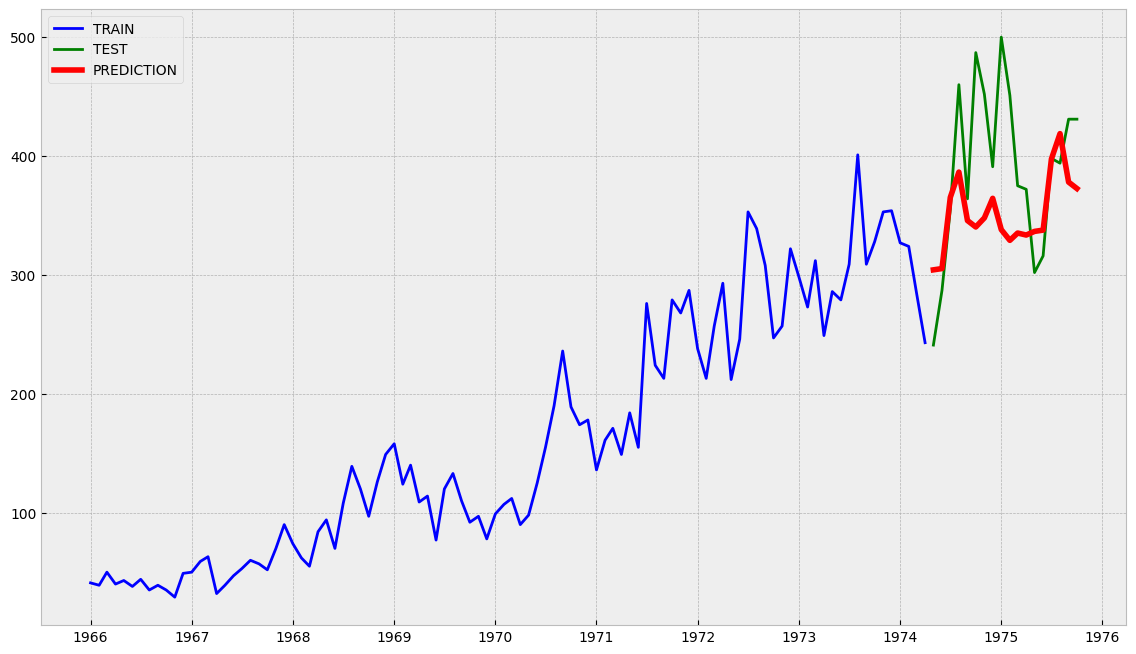

In [161]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(train, color='blue', linewidth='2', label='TRAIN')
    plt.plot(test, color='green', linewidth='2', label='TEST')
    plt.plot(pred, color='red', linewidth='4', label='PREDICTION')
    plt.legend()

## Оптимизация гиперпараметров модели

### Функция оптимизатора

In [174]:
def tes_optimizer(train, test, abg, trend_mode='add', seasonal_mode='add', seasonal_period=12, step=18):
    """This function to optimize hyperparameters for the TES model

    Args:
        train (pd.Series): train dataset
        test (pd.Series): test dataset
        abg (list): a tuple list that holds tuple of alpha, beta, gamma values
        trend_mode (str, optional): 'add' || 'mul' . Is the trend additive or multiplying? Defaults to 'add'.
        seasonal_mode (str, optional): 'add' || 'mul' . Is the seasonality additive or multiplying?. Defaults to 'add'.
        seasonal_period (int, optional): Step number that evaluates for the seasonal period. Defaults to 12.
        step (int, optional): How many steps later will the model that created with the train dataset forecast?. Defaults to 48.

    Returns:
        [float, float, float, float]: best_alpha, best_beta, best_gamma, best_mae
    """
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")

    for comb in abg: # visit the each combination
        tes_model = ExponentialSmoothing(train, trend=trend_mode, seasonal=seasonal_mode, seasonal_periods=seasonal_period).\
            fit(smoothing_level=comb[0], smoothing_trend=comb[1], smoothing_seasonal=comb[2]) # 0: alpha, 1: beta, 2: gamma. Creates a new TES instance by using each combination
        y_pred = tes_model.forecast(step) # forecast the `step` step later by using the TES instance
        mae = mean_absolute_error(test, y_pred) # calculate the MAE (mean absolute error)
        if mae < best_mae: # mark the best parameters
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae
    

### Создаем список кортежей гиперпараметров:

In [167]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)

In [168]:
print(f"Alphas: {alphas}\nBetas: {betas}\nGammas: {gammas}")

Alphas: [0.1 0.3 0.5 0.7 0.9]
Betas: [0.1 0.3 0.5 0.7 0.9]
Gammas: [0.1 0.3 0.5 0.7 0.9]


Создаем список кортежей, которые содержат все возможные комбинации значений гиперпараметров:

In [170]:
abg = list(itertools.product(alphas, betas, gammas))

### Используем этот список в качестве аргумента функции tes_optimizer

In [175]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, test, abg)

/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.1, 0.1, 0.1, 52.53]
[0.1, 0.1, 0.3, 53.32]
[0.1, 0.1, 0.5, 53.12]
[0.1, 0.1, 0.7, 53.68]
[0.1, 0.1, 0.9, 54.99]
[0.1, 0.3, 0.1, 71.58]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.1, 0.3, 0.3, 62.29]
[0.1, 0.3, 0.5, 59.39]
[0.1, 0.3, 0.7, 58.24]
[0.1, 0.3, 0.9, 54.53]
[0.1, 0.5, 0.1, 70.72]
[0.1, 0.5, 0.3, 61.21]
[0.1, 0.5, 0.5, 57.95]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.1, 0.5, 0.7, 60.77]
[0.1, 0.5, 0.9, 75.32]
[0.1, 0.7, 0.1, 70.75]
[0.1, 0.7, 0.3, 65.4]
[0.1, 0.7, 0.5, 107.77]
[0.1, 0.7, 0.7, 199.78]
[0.1, 0.7, 0.9, 190.84]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.1, 0.9, 0.1, 112.52]
[0.1, 0.9, 0.3, 164.4]
[0.1, 0.9, 0.5, 291.73]
[0.1, 0.9, 0.7, 292.16]
[0.1, 0.9, 0.9, 210.92]
[0.3, 0.1, 0.1, 83.09]
[0.3, 0.1, 0.3, 74.66]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.3, 0.1, 0.5, 68.13]
[0.3, 0.1, 0.7, 68.53]
[0.3, 0.1, 0.9, 74.72]
[0.3, 0.3, 0.1, 150.74]
[0.3, 0.3, 0.3, 124.84]
[0.3, 0.3, 0.5, 97.98]
[0.3, 0.3, 0.7, 88.79]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.3, 0.3, 0.9, 94.91]
[0.3, 0.5, 0.1, 237.7]
[0.3, 0.5, 0.3, 188.23]
[0.3, 0.5, 0.5, 144.84]
[0.3, 0.5, 0.7, 125.25]
[0.3, 0.5, 0.9, 104.58]
[0.3, 0.7, 0.1, 325.75]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.3, 0.7, 0.3, 282.66]
[0.3, 0.7, 0.5, 223.15]
[0.3, 0.7, 0.7, 155.59]
[0.3, 0.7, 0.9, 90.14]
[0.3, 0.9, 0.1, 390.5]
[0.3, 0.9, 0.3, 355.56]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.3, 0.9, 0.5, 261.42]
[0.3, 0.9, 0.7, 117.54]
[0.3, 0.9, 0.9, 60.87]
[0.5, 0.1, 0.1, 119.65]
[0.5, 0.1, 0.3, 112.66]
[0.5, 0.1, 0.5, 96.34]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.5, 0.1, 0.7, 76.87]
[0.5, 0.1, 0.9, 60.26]
[0.5, 0.3, 0.1, 229.02]
[0.5, 0.3, 0.3, 217.88]
[0.5, 0.3, 0.5, 183.39]
[0.5, 0.3, 0.7, 120.25]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.5, 0.3, 0.9, 60.89]
[0.5, 0.5, 0.1, 325.6]
[0.5, 0.5, 0.3, 319.49]
[0.5, 0.5, 0.5, 275.8]
[0.5, 0.5, 0.7, 154.18]
[0.5, 0.5, 0.9, 61.91]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.5, 0.7, 0.1, 387.23]
[0.5, 0.7, 0.3, 399.04]
[0.5, 0.7, 0.5, 370.61]
[0.5, 0.7, 0.7, 222.49]
[0.5, 0.7, 0.9, 103.23]
[0.5, 0.9, 0.1, 422.43]
[0.5, 0.9, 0.3, 475.59]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.5, 0.9, 0.5, 488.97]
[0.5, 0.9, 0.7, 375.95]
[0.5, 0.9, 0.9, 230.67]
[0.7, 0.1, 0.1, 144.37]
[0.7, 0.1, 0.3, 142.11]
[0.7, 0.1, 0.5, 136.98]
[0.7, 0.1, 0.7, 122.73]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.7, 0.1, 0.9, 96.27]
[0.7, 0.3, 0.1, 263.62]
[0.7, 0.3, 0.3, 266.33]
[0.7, 0.3, 0.5, 275.57]
[0.7, 0.3, 0.7, 268.61]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.7, 0.3, 0.9, 200.04]
[0.7, 0.5, 0.1, 347.07]
[0.7, 0.5, 0.3, 363.42]
[0.7, 0.5, 0.5, 419.4]
[0.7, 0.5, 0.7, 452.61]
[0.7, 0.5, 0.9, 335.7]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.7, 0.7, 0.1, 393.09]
[0.7, 0.7, 0.3, 420.15]
[0.7, 0.7, 0.5, 532.45]
[0.7, 0.7, 0.7, 608.49]
[0.7, 0.7, 0.9, 357.44]
[0.7, 0.9, 0.1, 414.27]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.7, 0.9, 0.3, 429.0]
[0.7, 0.9, 0.5, 594.12]
[0.7, 0.9, 0.7, 589.06]
[0.7, 0.9, 0.9, 312.18]
[0.9, 0.1, 0.1, 156.88]
[0.9, 0.1, 0.3, 152.47]
[0.9, 0.1, 0.5, 157.72]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.9, 0.1, 0.7, 176.02]
[0.9, 0.1, 0.9, 177.05]
[0.9, 0.3, 0.1, 270.61]
[0.9, 0.3, 0.3, 259.62]
[0.9, 0.3, 0.5, 287.21]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.9, 0.3, 0.7, 353.37]
[0.9, 0.3, 0.9, 324.75]
[0.9, 0.5, 0.1, 331.51]
[0.9, 0.5, 0.3, 298.02]
[0.9, 0.5, 0.5, 351.5]
[0.9, 0.5, 0.7, 455.17]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.9, 0.5, 0.9, 355.94]
[0.9, 0.7, 0.1, 344.99]
[0.9, 0.7, 0.3, 262.21]
[0.9, 0.7, 0.5, 360.8]
[0.9, 0.7, 0.7, 459.09]
[0.9, 0.7, 0.9, 315.29]


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequen

[0.9, 0.9, 0.1, 319.92]
[0.9, 0.9, 0.3, 183.93]
[0.9, 0.9, 0.5, 352.23]
[0.9, 0.9, 0.7, 323.72]
[0.9, 0.9, 0.9, 267.51]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.1 best_mae: 52.5283


/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Лучшие значения гиперпараметров : best_alpha = 0.1 best_beta = 0.1 best_gamma = 0.1

### Обучим новую модуль с полученными параметрами:

In [176]:
final_tes_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal="add",
    seasonal_periods=12
).fit(
    smoothing_level=0.1,
    smoothing_trend=0.1,
    smoothing_seasonal=0.1
)

/home/andrew/.cache/pypoetry/virtualenvs/ts-studying-gf7ATlvB-py3.12/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [180]:
tes_values = final_tes_model.fittedvalues
final_predict = final_tes_model.forecast(18)

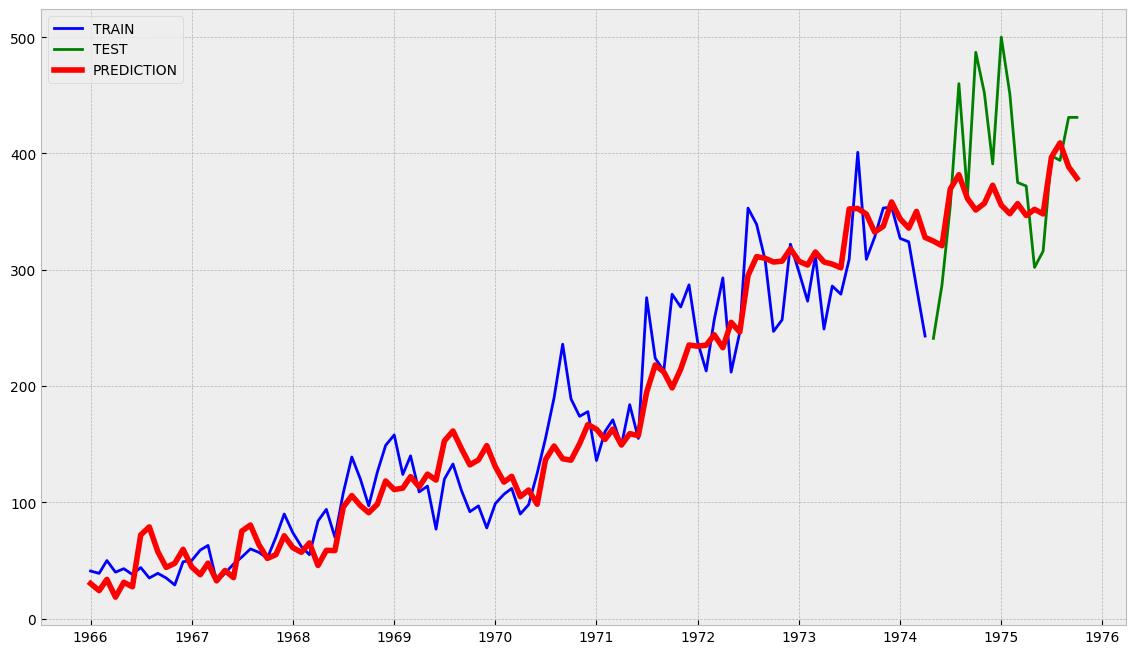

In [183]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(train, color='blue', linewidth='2', label='TRAIN')
    plt.plot(test, color='green', linewidth='2', label='TEST')
    plt.plot(pd.concat([tes_values, final_predict]), color='red', linewidth='4', label='PREDICTION')
    plt.legend()